## BeerAdvocate: Data Exploration

In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/farouk/anaconda3/envs/py3-9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**SETUP**

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

2022-11-10 16:09:13,454 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tu5f8fzq', purging
2022-11-10 16:09:13,495 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-sh_mh_27', purging
2022-11-10 16:09:13,503 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-qp68w8ek', purging
2022-11-10 16:09:13,508 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-m__nkpkz', purging
2022-11-10 16:09:13,517 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5evftnbn', purging
2022-11-10 16:09:13,518 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h47bgb99', purging
2022-11-10 16:09:13,537 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kvtvwwzk', purging

LocalCluster(f8fcb4a1, 'tcp://127.0.0.1:37747', workers=4, threads=8, memory=7.66 GiB)

### BeerAdvocate - users.csv

**[I] Loading the Data**

In [3]:
users_cols = [
    "nbr_ratings", 
    "nbr_reviews", 
    "user_id", 
    "user_name", 
    "joined",
    "location"]

users_df = ing.read_csv(
    path=ing.build_path(folderind="ba", fileind="users"),
    assume_missing=True,
    keepcols=users_cols)

users_df.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820.0,465.0,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521.0,2504.0,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797.0,1143.0,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31.0,31.0,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604.0,604.0,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


**[II] Data Transformation**

Summary:

- **Renaming Columns**: "nbr_ratings" to "n_ratings", "nbr_reviews" to "n_reviews", "user_id" to "uid", "user_name" to "username".
- **Converting Data Types**: "n_ratings", "n_reviews" to int & "username", "uid", "location" to str.
- **Converting "nan" to None**: in "location".
- **Creating an additional "country" column from "location"**: by extracting the country name from the location (example: "United States, Texas" location belongs to country "United States").
- **Converting the "joined" column values**: float values (time in seconds, reference is Jan.1st 1970 at 00:00) to pandas.Timestamp. Implicit conversion of NaN to NaT. 

Renaming the columns

In [4]:
cols_renaming = {
    "nbr_ratings": "n_ratings",
    "nbr_reviews": "n_reviews",
    "user_id": "uid",
    "user_name": "username"
}

users_df = users_df.rename(columns=cols_renaming)
users_df.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location'], dtype='object')

Converting data types

In [5]:
users_df.dtypes

n_ratings    float64
n_reviews    float64
uid           object
username      object
joined       float64
location      object
dtype: object

In [6]:
users_dtypes = {
    "n_ratings": np.int32, 
    "n_reviews": np.int32, 
    "uid": str, 
    "username": str,
    "location": str
}

users_df = users_df.astype(users_dtypes)
users_df.dtypes

n_ratings      int32
n_reviews      int32
uid           object
username      object
joined       float64
location      object
dtype: object

Converting "nan" strings in "location" to None

In [7]:
users_df["location"] = users_df.location.apply(prc.str_nan_to_none)

Converting the "joined" column values (time in seconds) to Timestamps

In [8]:
users_df["joined"] = ddf.to_datetime(users_df.joined, unit="s")
users_df.head(5)

,n_ratings,n_reviews,uid,username,joined,location
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland


In [9]:
# CHECK
print("CHECK: max date year must be at most 2017, the last year data was collected.")
users_df.joined.max()

CHECK: max date year must be at most 2017, the last year data was collected.


Timestamp('2017-07-31 10:00:00')

Appending the Country of Each Territory

In [10]:
users_df["country"] = users_df["location"].apply(lambda territory: prc.get_country(territory))
users_df.head(5)

,n_ratings,n_reviews,uid,username,joined,location,country
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland,Northern Ireland


**[III] Descriptive Statistics & Distributions**

Summary:

* **Missing values**: none, except for "location" that may contain "nan" (previously converted to None) and "joined" that may contain NaN (previously implictely converted to NaT).
* **users**:
  - 153'704 unique users.
  - $\approx$ 20.3% of users are of unknown location.
  - the top 5 countries in terms of number of users with respect to the total number of users and to the total of number of users with known location respectively are:
    1. United States	($\approx$ 73.6%, $\approx$ 92.4%)
    2. Canada ($\approx$ 2.1%, $\approx$ 2.7%)
    3. England ($\approx$ 0.05%, $\approx$ 0.06%)
    4. Australia ($\approx$ 0.03%, $\approx$ 0.04%)
    5. Germany ($\approx$ 0.02%, $\approx$ 0.03%)
* **ratings**:
  - 8'393'032 ratings in total.
  - heavy-tailed distribution of the number of ratings per user.
  - 50% of users have at most 3 ratings.
  - the mean number of ratings $\approx 54.6$ is quite low while the standard deviation $\approx 252.38$ is very high.
  - the top 5 countries in terms of the number of ratings are:
    1. United States ($\approx$ 87%)
    2. Canada ($\approx$ 3.2%)
    3. England ($\approx$ 0.04%)
    4. Australia ($\approx$ 0.04%)
    5. Sweden ($\approx$ 0.03%)
* **reviews**:
  - 50% of users have 0 reviews.
  - the mean number of reviews $\approx 16.84$ is quite low while the standard deviation $\approx 139.84$ is very high.
* **country**:
  - users are located in 145 different countries. 

In [11]:
users_df.describe()

,n_ratings,n_reviews
count,153704.000000,153704.000000
mean,54.605163,16.847876
std,252.388790,139.846706
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,16.000000,2.000000
max,12046.000000,8970.000000


user_id

In [12]:
print("Is any user ID missing ?")
users_df.uid.isna().any()

Is any user ID missing ?


False

In [13]:
print("How many unique users ?")
n_users = len(users_df.uid.unique())
n_users

How many unique users ?


153704

location

In [14]:
print("Is there a user with unknown location ?")
users_df.location.isna().any()

Is there a user with unknown location ?


True

In [15]:
print("How many users have an unknown location ?")
n_users_unknown_loc = users_df.location.isna().sum()
n_users_unknown_loc

How many users have an unknown location ?


31279

In [16]:
print("What fraction do these users make up of the total number of users ?")
n_users_unknown_loc / n_users

What fraction do these users make up of the total number of users ?


0.2035015354187269

In [17]:
print("Where are all users located ?")
all_countries = users_df.country[~users_df.country.isna()].unique()
all_countries.sort()
all_countries

Where are all users located ?


array(['Afghanistan', 'Albania', 'American Samoa', 'Andorra', 'Angola',
       'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Aotearoa',
       'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Bermuda', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Bouvet Island', 'Brazil',
       'British Indian Ocean Territory', 'Bulgaria', 'Burkina Faso',
       'Cambodia', 'Canada', 'Cayman Islands', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Ethiopia', 'Faroe Islands', 'Fiji Islands', 'Finland', 'France',
       'Germany', 'Gibraltar', 'Greece', 'Guam', 'Guatemala', 'Guernsey',
       'Haiti', 'Heard and McDonald Islands', 'Honduras', 'Hong Kong',
       'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland',
       'Isle of Man', 

In [18]:
print("How many different locations are there ?")
len(all_countries)

How many different locations are there ?


145

<AxesSubplot:title={'center':'Number of Users Across All Countries except the US'}, xlabel='country (represented via its index entry)', ylabel="users' count">

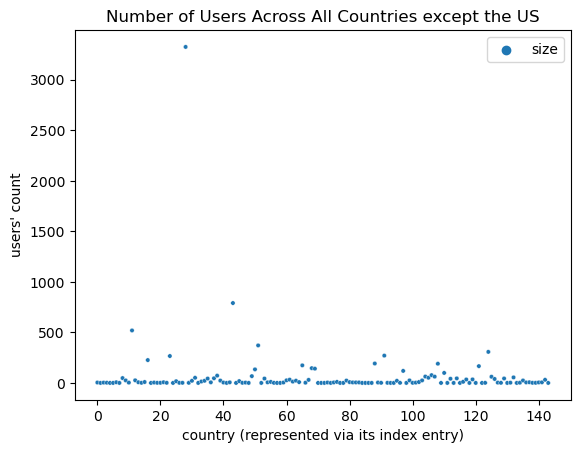

In [19]:
n_users_per_country_wout_us = users_df[\
    (~users_df.country.isna()) &\
    (users_df.country != "United States")].groupby("country", as_index=False).size()

fig, ax = plt.subplots(1,1)
ax.set_title("Number of Users Across All Countries except the US")
ax.set_ylabel("users' count")
ax.set_xlabel("country (represented via its index entry)")
sns.scatterplot(data=n_users_per_country_wout_us, ax=ax, s=10)

In [21]:
print("List of countries with at least 100 users")
n_users_per_country = users_df.groupby("country", as_index=False).size()
countries_atleast_100users = n_users_per_country[n_users_per_country["size"] >= 100]
countries_atleast_100users["users_frac"] = countries_atleast_100users["size"] / users_df.location[~ users_df.location.isna()].size
countries_atleast_100users = countries_atleast_100users.sort_values(by="size", ascending=False)
countries_atleast_100users

List of countries with at least 100 users


/tmp/ipykernel_16223/3478117932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_atleast_100users["users_frac"] = countries_atleast_100users["size"] / users_df.location[~ users_df.location.isna()].size


,country,size,users_frac
137,United States,113223,0.924836
28,Canada,3324,0.027151
43,England,791,0.006461
11,Australia,520,0.004247
51,Germany,372,0.003039
124,Sweden,308,0.002516
91,Netherlands,271,0.002214
23,Brazil,267,0.002181
16,Belgium,227,0.001854
88,Mexico,193,0.001576


n_ratings

In [22]:
print("Is there a user with unknown number of ratings ?")
users_df.n_ratings.isna().any()

Is there a user with unknown number of ratings ?


False

In [23]:
print("Total number of ratings")
total_n_ratings = users_df.n_ratings.sum()
total_n_ratings

Total number of ratings


8393032

<AxesSubplot:title={'center':'Distribution of Ratings Across All Users'}, xlabel='ratings', ylabel='occurences'>

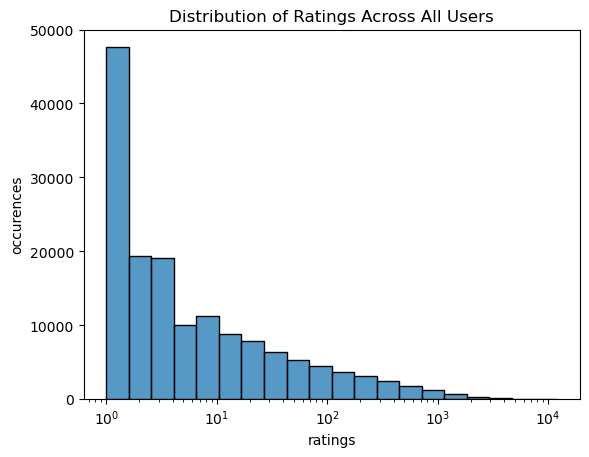

In [24]:
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of Ratings Across All Users")
ax.set_ylabel("occurences")
ax.set_xlabel("ratings")
sns.histplot(data=users_df, x="n_ratings", ax=ax, bins=20, log_scale=True)


<AxesSubplot:title={'center':'Number of Ratings Across All Countries except the US'}, xlabel='country (represented by its entry index)', ylabel="ratings' count">

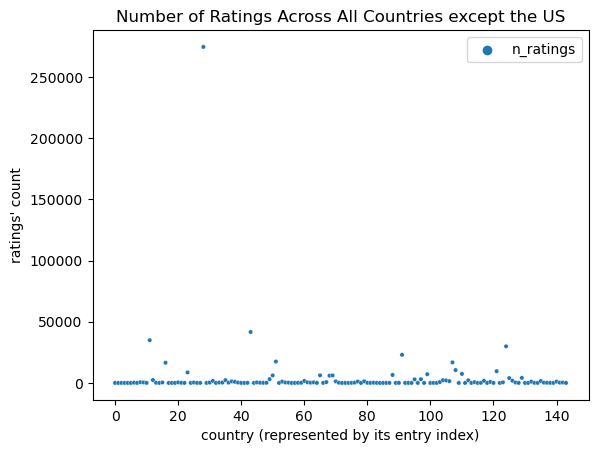

In [25]:
n_ratings_per_country = users_df[\
    (~users_df.country.isna()) &\
    (users_df.country != "United States")].groupby("country", as_index=False).agg({"n_ratings": np.sum})

fig, ax = plt.subplots(1,1)
ax.set_title("Number of Ratings Across All Countries except the US")
ax.set_ylabel("ratings' count")
ax.set_xlabel("country (represented by its entry index)")
sns.scatterplot(data=n_ratings_per_country, ax=ax, s=10)

In [26]:
print("List of countries with at least 10'000 ratings")
min_n_ratings = 10_000
n_ratings_per_country = users_df[~users_df.country.isna()].groupby("country", as_index=False).agg({"n_ratings": np.sum})
countries_atleast_10Kratings = n_ratings_per_country[n_ratings_per_country.n_ratings >= min_n_ratings]
countries_atleast_10Kratings["ratings_frac"] = countries_atleast_10Kratings.n_ratings[n_ratings_per_country.n_ratings >= min_n_ratings] / \
    total_n_ratings
countries_atleast_10Kratings = countries_atleast_10Kratings.sort_values(by="n_ratings", ascending=False)
countries_atleast_10Kratings

List of countries with at least 10'000 ratings


/tmp/ipykernel_16223/3676339592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countries_atleast_10Kratings["ratings_frac"] = countries_atleast_10Kratings.n_ratings[n_ratings_per_country.n_ratings >= min_n_ratings] / total_n_ratings


,country,n_ratings,ratings_frac
137,United States,7303870,0.870230
28,Canada,274512,0.032707
43,England,41597,0.004956
11,Australia,34915,0.004160
124,Sweden,29914,0.003564
91,Netherlands,22952,0.002735
51,Germany,17460,0.002080
107,Romania,16823,0.002004
16,Belgium,16478,0.001963
108,Russia,10521,0.001254


n_reviews

In [ ]:
print("Is there a user with unknown number of reviews ?")
users_df.n_reviews.isna().any()

In [ ]:
print("Total number of reviews")
total_n_reviews = users_df.n_reviews.sum()
total_n_reviews

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of Reviews Across All Users")
ax.set_ylabel("occurences")
ax.set_xlabel("reviews")
sns.histplot(data=users_df, x="n_reviews", ax=ax, bins=20, log_scale=True)

In [ ]:
print("List of countries with at least 1'000 reviews")
min_n_reviews = 1_000
n_reviews_per_country = users_df[~users_df.country.isna()].groupby("country", as_index=False).agg({"n_reviews": np.sum})
countries_atleast_1Kreviews = n_reviews_per_country[n_reviews_per_country.n_reviews >= min_n_reviews]
countries_atleast_1Kreviews["reviews_frac"] = countries_atleast_1Kreviews.n_reviews[n_reviews_per_country.n_reviews >= min_n_reviews] / total_n_reviews
countries_atleast_1Kreviews = countries_atleast_1Kreviews.sort_values(by="n_reviews", ascending=False)
countries_atleast_1Kreviews

joined